1.	Приложен ноутбук, в котором реализованы функции для генирации из большого датасета меньшая его копия. Вам нужно перенести функции из этого ноутбука в класс датасет и сделать следующее: 

a.	Сгенерировать меньший датасет из 8-10 классов движения

b.	Обучить уже существующую модель (предварительно проанализировав какие параметры модели нужно изменить)

c.	Изменить модель: посмотреть зависимость от количества LSTM модулей в нашей модели  

d.	Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество. Желательно сделать так, чтобы длина последовательности передавалась как атрибут класса.



In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

In [22]:
PATH_TO_DATA = "../content/drive/MyDrive/Colab_data/nturgbd_skeletons_s001_to_s017/nturgb+d_skeletons/"
PATH_TO_MISSING_DATA = "../content/drive/MyDrive/Colab_data/NTU_RGBD_samples_with_missing_skeletons.txt"

In [15]:
training_subjects = list(range(0, 28)) #количество людей выполняющих действия
training_classes = [1, 3, 11, 15, 20, 31, 45, 52, 78, 99] # классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
training_cameras = [1, 2, 3] 

max_body_true = 1
max_body_kinect = 1

num_joint = 25
max_frame = 300 # Длина отрезка которую мы вычленяем из большого датасета

In [6]:
labelsDict = {1: 'drink water', 
          3: 'brushing teeth', 
          11: 'reading', 
          15: 'take off jacket', 
          20: 'put on a hat/cap', 
          31: 'pointing to something with finger', 
          45: 'touch chest (stomachache/heart pain)',
          52: 'pushing other person', 
          78: 'open bottle', 
          99: 'running on the spot'}
LABELS = list(labelsDict.values())
training_classes = list(labelsDict.keys())

In [7]:
class ProcessingDataset:
    
    files = None
    action_classes = None
    
    def __init__(self, data_path, broken_files_path , chonk_len=45):
        self.data_path = data_path
        self.broken_files_path = broken_files_path
        self.chonk_len = chonk_len
    
    def read_data(self):
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(self.broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(self.data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in training_classes and camera_id in training_cameras:  # and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename, action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
                        labels.append([action_class])
                        
        print("action classes: ", action_classes)
        print("action files: ", files_counter)
        
        self.files = files
        self.action_classes = action_classes
        
        return files, action_classes
    
    def get_nonzero_std(self, s): 
        index = s.sum(-1).sum(-1) != 0  
        s = s[index]
        if len(s) != 0:
            s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
        else:
            s = 0
        return s
    
    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence
    
    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data
    
    def create_coords_blocks(self, test_file):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(self.data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = self.chonk_len * int(len(test_frames)/self.chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == self.chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []


        return blocks, new_labels
    
    def mark_data(self):
        data = []
        labels = []
        ##########################################################################
        numbers = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0} #####
        ##################################################################
        for file in self.files:
            frames_blocks, label = self.create_coords_blocks(file)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] += len(label)
                data += frames_blocks
                labels += label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        
        return test_data

In [23]:
chonk_len=50

dataset = ProcessingDataset(data_path=PATH_TO_DATA, broken_files_path=PATH_TO_MISSING_DATA, chonk_len=chonk_len)

dataset.read_data()

test_data = dataset.mark_data()

test_data.info()
test_data.head()

action classes:  {31: 0, 11: 1, 45: 2, 20: 3, 52: 4, 3: 5, 15: 6, 1: 7}
action files:  {31: 120, 11: 120, 45: 120, 20: 120, 52: 120, 3: 120, 15: 120, 1: 120}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Columns: 3751 entries, 0 to labels
dtypes: float64(3750), int64(1)
memory usage: 30.9 MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3711,3712,3713,3714,3715,3716,3717,3718,3719,3720,3721,3722,3723,3724,3725,3726,3727,3728,3729,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739,3740,3741,3742,3743,3744,3745,3746,3747,3748,3749,labels
0,-0.109981,-0.235070,3.186546,-0.084741,0.060207,3.128725,-0.059984,0.348436,3.053449,-0.068761,0.485796,3.021212,-0.245573,0.256854,3.110188,-0.301260,-0.007016,3.137673,-0.286098,-0.219465,3.095867,-0.276193,-0.223087,3.099662,0.096735,0.227487,3.042589,0.119892,-0.029746,3.056010,0.089409,-0.242538,3.052773,0.066447,-0.261336,3.062905,-0.183274,-0.228654,3.166321,-0.206440,...,-0.177140,-0.210581,3.139621,-0.199251,-0.494073,3.254823,-0.211565,-0.789671,3.356531,-0.198846,-0.846156,3.232846,-0.026199,-0.217952,3.147114,-0.014620,-0.503024,3.246256,-0.024650,-0.788561,3.363125,-0.013749,-0.845057,3.239374,-0.055805,0.286811,3.084648,-0.496266,0.347531,2.519418,-0.469246,0.293751,2.527600,0.089892,-0.363103,3.051107,0.060545,-0.268241,3.046704,0
1,-0.391813,-0.867580,3.242395,-0.403428,-0.567627,3.245990,-0.411866,-0.270204,3.235996,-0.404656,-0.174672,3.215805,-0.577512,-0.353568,3.215704,-0.643871,-0.532692,3.191800,-0.512711,-0.539281,3.042809,-0.453642,-0.508748,3.009512,-0.255968,-0.349625,3.262564,-0.184499,-0.512280,3.308238,-0.330819,-0.505375,3.087809,-0.353801,-0.478077,2.997794,-0.463521,-0.857837,3.190450,-0.491589,...,-0.459455,-0.845488,3.212503,-0.492011,-1.175423,3.171972,-0.495456,-1.462769,3.231628,-0.504984,-1.528879,3.153023,-0.312835,-0.844437,3.238642,-0.264388,-1.173538,3.206803,-0.270637,-1.460361,3.284710,-0.235150,-1.527121,3.218748,-0.397318,-0.341160,3.260258,-0.267668,-0.407411,2.952377,-0.369865,-0.413976,2.940470,-0.478473,-0.474386,2.995918,-0.363669,-0.414389,2.935200,1
2,-0.947688,-0.467857,3.561262,-0.763069,-0.533852,3.819500,-0.582073,-0.601320,4.067874,-0.514054,-0.528356,4.100576,-0.726922,-0.656325,4.063581,-0.878938,-0.747055,4.093147,-0.664459,-0.651642,3.988598,-0.626248,-0.641526,4.032578,-0.812882,-0.730364,4.026525,-0.757280,-0.761244,3.769869,-0.814105,-0.814428,3.534058,-0.784730,-0.810869,3.511060,-0.907814,-0.463321,3.602054,-0.951891,...,-0.937919,-0.517054,3.641314,-0.961445,-0.673367,3.319641,-0.937437,-1.080837,3.153407,-0.978305,-1.076904,3.017252,-0.979468,-0.542998,3.501842,-1.030348,-0.664442,3.168005,-0.986370,-1.066829,2.990033,-0.902719,-1.094932,2.901551,-0.601521,-0.588024,3.994010,-0.604076,-0.552349,4.051658,-0.653113,-0.514770,4.077533,-0.967847,-0.838130,3.624573,-0.928574,-0.834036,3.581875,1
3,-0.971490,-0.533757,3.603469,-0.784170,-0.574040,3.840014,-0.608345,-0.618228,4.068150,-0.512444,-0.533380,4.084466,-0.727679,-0.641491,4.070400,-0.910583,-0.625113,4.053182,-0.671657,-0.539947,4.040383,-0.678183,-0.560593,4.072613,-0.844120,-0.742220,4.025411,-0.745628,-0.763491,3.781000,-0.897883,-0.811585,3.599085,-0.930500,-0.827664,3.603723,-0.942594,-0.518174,3.644277,-0.963958,...,-0.974358,-0.437357,3.611453,-0.971875,-0.623857,3.306303,-0.935344,-1.074735,3.150977,-0.853980,-1.113540,3.067844,-0.995724,-0.466075,3.469025,-1.001853,-0.619244,3.144379,-0.973311,-0.989921,3.104895,-0.969824,-1.068614,2.996188,-0.643807,-0.600178,4.007006,-0.354505,-0.552468,3.788407,-0.362270,-0.502304,3.841400,-0.973526,-0.837566,3.643539,-0.923435,-0.833913,3.586640,1
4,0.012459,-0.215443,2.818315,0.021373,0.077382,2.810672,0.029685,0.363494,2.790704,0.042616,0.492423,2.786590,-0.119801,0.252505,2.760492,-0.162933,0.011876,2.767920,-0.167391,-0.201744,2.711453,-0.163120,-0.246322,2.716755,0.175903,0.230206,2.760752,0.197262,-0.006154,2.768993,0.189576,-0.204411,2.707593,0.183367,-0.270360,2.703117,-0.053446,-0.208903,2.781695,-0.061038,...,-0.063333,-0.228273,2.861362,-0.061417,-0.518548,2.859242,-0.081607,-0.810308,2.876351,-0.087735,-0.871569,2.766918,0.070205,-0.232893,2.852257,0.059495,-0.507259,2.860074,0.064658,-0.815432,2.886213,0.056873,-0.876666,2.776783,0.

In [24]:
test_data.to_csv("../content/drive/MyDrive/Colab_data/skeletons.csv", index=False)


In [25]:
class LSTM_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.dr = nn.Dropout2d(0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,inputs):
        x = inputs
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [26]:
# LSTM setups
rnn = LSTM_net(
    input_dim=25*3,
    hidden_dim=128,
    output_dim=len(training_classes),
    layer_num=1
)
rnn.to('cpu')

LSTM_net(
  (lstm): LSTM(75, 128, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [27]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(chonk_len, 25*3)
        label = self.labels[idx]
        
        if self.transform != None:
            item = transform(item)

        return (item, label)

In [28]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {round(s)}s'

In [29]:
dataset = Skeleton_Dataset(file_path = "../content/drive/MyDrive/Colab_data/skeletons.csv", transform=None)

train_len = int(0.75*len(dataset))
test_len = len(dataset) - train_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [30]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    params=rnn.parameters(), 
    lr=0.001, 
    momentum=0.9
)

all_losses = []
start = time.time()
counter = 0

for epoch in range(400):
    current_loss = 0
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else f'✗ ({category})'
            print(f'epoch = {epoch}; iter = {i}; time = {timeSince(start)}; loss = {loss}  / {guess} {correct}')

        counter += 1
                  
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch = 0; iter = 0; time = 0m 0s; loss = 2.2611849308013916  / pushing other person ✗ (brushing teeth)
epoch = 9; iter = 41; time = 0m 36s; loss = 2.070723056793213  / pointing to something with finger ✓
epoch = 19; iter = 31; time = 1m 10s; loss = 1.9387489557266235  / touch chest (stomachache/heart pain) ✓
epoch = 29; iter = 21; time = 1m 44s; loss = 1.984326720237732  / take off jacket ✓
epoch = 39; iter = 11; time = 2m 19s; loss = 1.9281703233718872  / pointing to something with finger ✗ (take off jacket)
epoch = 49; iter = 1; time = 2m 53s; loss = 1.6731774806976318  / pointing to something with finger ✓
epoch = 58; iter = 42; time = 3m 28s; loss = 1.832497477531433  / pointing to something with finger ✓
epoch = 68; iter = 32; time = 4m 3s; loss = 1.9307308197021484  / pointing to something with finger ✗ (take off jacket)
epoch = 78; iter = 22; time = 4m 37s; loss = 1.9393868446350098  / reading ✗ (put on a hat/cap)
epoch = 88; iter = 12; time = 5m 11s; loss = 2.090620994567871  

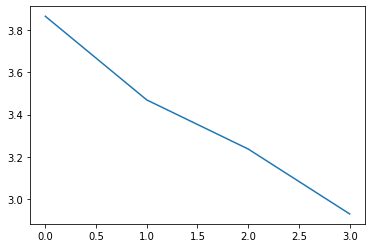

In [31]:
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()



In [32]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0], data[1]
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network: ',  (100 * right / counter))

Accuracy of the network:  44.64944649446495
